In [1]:

!pip install -q kaggle

# Move your kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
#!/bin/bash
!kaggle datasets download ejlok1/cremad


Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
100% 451M/451M [00:04<00:00, 95.7MB/s]
100% 451M/451M [00:04<00:00, 100MB/s] 


In [ ]:
!unzip cremad.zip -d crema_dataset

# Importing Libraries

In [4]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Dataset

In [5]:
Crema = "/content/crema_dataset"

In [14]:
import os
import pandas as pd

# Define the Crema directory
Crema = "/content/crema_dataset/AudioWAV/"

# List files in the directory
crema_directory_list = os.listdir(Crema)

# Initialize lists
file_emotion = []
file_path = []

for file in crema_directory_list:
    # Construct full file path
    full_path = os.path.join(Crema, file)
    file_path.append(full_path)

    # Extract emotions from the filename
    part = file.split('_')
    if len(part) > 2:  # Ensure the filename has at least 3 parts
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    else:
        file_emotion.append('Unknown')

# Create DataFrames
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine DataFrames
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Preview the DataFrame
print(Crema_df.head())


  Emotions                                               Path
0    angry  /content/crema_dataset/AudioWAV/1023_IWL_ANG_X...
1      sad  /content/crema_dataset/AudioWAV/1065_MTI_SAD_X...
2      sad  /content/crema_dataset/AudioWAV/1050_IWL_SAD_X...
3  disgust  /content/crema_dataset/AudioWAV/1059_ITH_DIS_X...
4    angry  /content/crema_dataset/AudioWAV/1033_TSI_ANG_X...


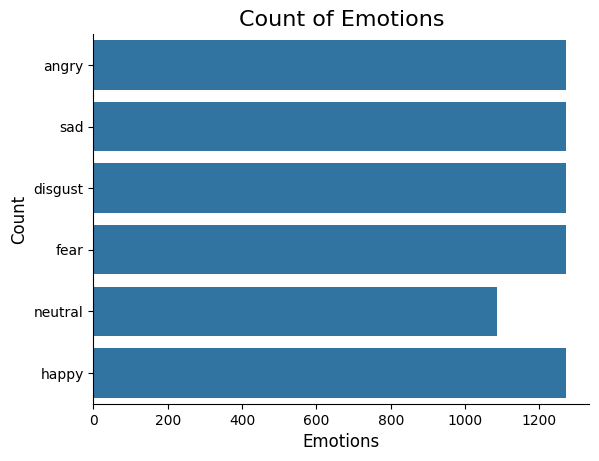

In [15]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualization

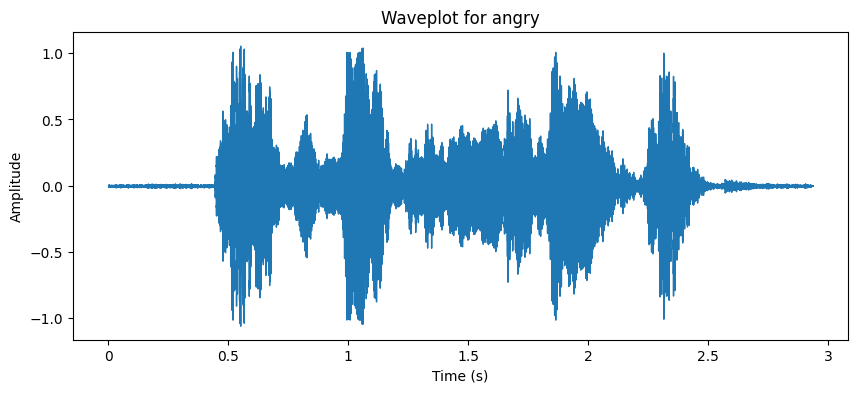

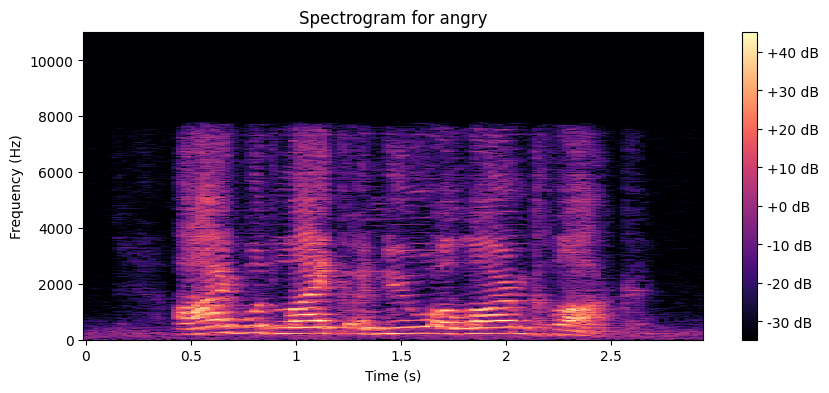

In [17]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define the helper functions
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveplot for {emotion}")
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    stft = librosa.stft(data)
    spectrogram = librosa.amplitude_to_db(abs(stft))
    plt.figure(figsize=(10, 4))
    plt.title(f"Spectrogram for {emotion}")
    librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Select emotion and path
emotion = 'angry'
filtered_paths = Crema_df.Path[Crema_df.Emotions == emotion]

# Check if any file matches the emotion
if not filtered_paths.empty:
    path = np.array(filtered_paths)[0]  # Select the first matching file
    # Load audio data
    data, sampling_rate = librosa.load(path)

    # Generate visualizations
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)

    # Play audio
    Audio(path)
else:
    print(f"No files found for emotion: {emotion}")


# MFCC Extraction

In [18]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

<ipython-input-18-5372901cec1b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Crema_df.replace({'Emotions':labels},inplace=True)


In [20]:
import librosa
import numpy as np

# Parameters
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050

# Data dictionary
data = {
    "labels": [],
    "mfcc": []
}

# Loop through files
for i in range(len(Crema_df)):
    try:
        # Append label
        data['labels'].append(Crema_df.iloc[i, 0])

        # Validate file path
        if not os.path.exists(Crema_df.iloc[i, 1]):
            print(f"File not found: {Crema_df.iloc[i, 1]}")
            continue

        # Load audio
        signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE, duration=5.0)  # Limit to 5 seconds
        signal = librosa.util.normalize(signal)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T  # Transpose for frame-wise MFCCs
        data["mfcc"].append(np.asarray(mfcc))
    except Exception as e:
        print(f"Error processing file {Crema_df.iloc[i, 1]}: {e}")
        continue

    # Print progress
    if i % 500 == 0:
        print(f"Processed {i} files")


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files


# Padding MFCC to make them of equal length

In [22]:
import numpy as np

# Define a fixed length for all MFCC arrays (e.g., 300 frames)
max_length = 300

# Function to pad or truncate MFCC arrays
def pad_or_truncate(mfcc, max_length):
    if mfcc.shape[0] > max_length:
        return mfcc[:max_length, :]
    elif mfcc.shape[0] < max_length:
        padding = np.zeros((max_length - mfcc.shape[0], mfcc.shape[1]))
        return np.vstack((mfcc, padding))
    else:
        return mfcc

# Apply padding or truncation to all MFCC arrays
data['mfcc'] = [pad_or_truncate(mfcc, max_length) for mfcc in data['mfcc']]

# Convert to numpy arrays
X = np.asarray(data['mfcc'])  # Shape: (num_samples, max_length, num_features)
y = np.asarray(data['labels'])  # Shape: (num_samples,)


In [23]:
print("Shape of X:", X.shape)  # Expected: (num_samples, max_length, num_features)
print("Shape of y:", y.shape)  # Expected: (num_samples,)


Shape of X: (7442, 300, 13)
Shape of y: (7442,)


In [44]:
import librosa
import numpy as np
import os

# Parameters
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050
max_length = 300  # Fixed number of frames for padding or truncation

# Data dictionary
data = {
    "labels": [],
    "mfcc": []
}

# Function to pad or truncate MFCC arrays
def pad_or_truncate(mfcc, max_length):
    if mfcc.shape[0] > max_length:
        return mfcc[:max_length, :]
    elif mfcc.shape[0] < max_length:
        padding = np.zeros((max_length - mfcc.shape[0], mfcc.shape[1]))
        return np.vstack((mfcc, padding))
    else:
        return mfcc

# Loop through files
for i in range(len(Crema_df)):
    try:
        # Append label
        data['labels'].append(Crema_df.iloc[i, 0])

        # Validate file path
        if not os.path.exists(Crema_df.iloc[i, 1]):
            print(f"File not found: {Crema_df.iloc[i, 1]}")
            continue

        # Load audio
        signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE, duration=5.0)  # Limit to 5 seconds
        signal = librosa.util.normalize(signal)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

        # Compute Delta (first-order derivative)
        delta = librosa.feature.delta(mfcc)

        # Compute Delta-Delta (second-order derivative)
        delta_delta = librosa.feature.delta(mfcc, order=2)

        # Combine MFCC, Delta, and Delta-Delta features
        combined_features = np.vstack((mfcc, delta, delta_delta)).T  # Combine and transpose

        # Pad or truncate to fixed length
        padded_features = pad_or_truncate(combined_features, max_length)

        # Append to data
        data["mfcc"].append(padded_features)
    except Exception as e:
        print(f"Error processing file {Crema_df.iloc[i, 1]}: {e}")
        continue

    # Print progress
    if i % 500 == 0:
        print(f"Processed {i} files")

# Convert to numpy arrays
X = np.asarray(data['mfcc'])  # Shape: (num_samples, max_length, num_features)
y = np.asarray(data['labels'])  # Shape: (num_samples,)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files
Feature matrix shape: (7442, 300, 39)
Labels shape: (7442,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [46]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 300, 39) (5357,) (1340, 300, 39) (1340,) (745, 300, 39) (745,)


# Model

In [61]:
from tensorflow.keras.layers import GlobalAveragePooling1D

def build_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layers
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention: query = value = lstm_out
    context_vector = Concatenate()([attention, lstm_out])  # Combine attention output with LSTM output

    # Global average pooling across time dimension
    pooled_output = GlobalAveragePooling1D()(context_vector)

    # Fully connected layers
    dense = Dense(64, activation='relu')(pooled_output)
    dense = Dropout(0.3)(dense)

    # Output layer
    outputs = Dense(6, activation='softmax')(dense)

    # Define the model
    model = Model(inputs, outputs)

    return model


In [62]:
input_shape = (300, 39)  # Example: 300 timesteps, 39 features (MFCC + delta + delta-delta)
model = build_model(input_shape)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 300, 39)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_20          │ (None, 300, 256)       │        172,032 │ input_layer_11[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 300, 256)       │              0 │ bidirectional_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_21          │ (None, 300, 128)       │        164,352 │ dropout_32[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 300, 128)       │              0 │ bidirectional_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_10 (Attention)  │ (None, 300, 128)       │              0 │ dropout_33[0][0],      │
│                           │                        │                │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 300, 256)       │              0 │ attention_10[0][0],    │
│ (Concatenate)             │                        │                │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ concatenate_8[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 64)             │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 6)              │            390 │ dropout_34[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 353,222 (1.35 MB)

 Trainable params: 353,222 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.3182 - loss: 1.5956 - val_accuracy: 0.4418 - val_loss: 1.4153
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4221 - loss: 1.4039 - val_accuracy: 0.4530 - val_loss: 1.3322
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4650 - loss: 1.3293 - val_accuracy: 0.4679 - val_loss: 1.3275
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5107 - loss: 1.2507 - val_accuracy: 0.5045 - val_loss: 1.2593
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5350 - loss: 1.2089 - val_accuracy: 0.5119 - val_loss: 1.2706
Epoch 6/30
143/168 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5513 - loss: 1.1786

# Evaluation

In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.6295301914215088


In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')